
# TCAV Visualization Notebook

This notebook analyzes TCAV results for:

- ReDimNet (b5)
- Logistic probe (Fake vs Real)
- Stage4 layer

It assumes the file:
`tcav_ASVspoof_stage4_spoofwrapper.csv`
already exists.


In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import sys
from scipy.stats import ttest_ind

sns.set(style="whitegrid", context="talk")


In [2]:

PROJECT_ROOT = Path.cwd().parents[2]
sys.path.append(str(PROJECT_ROOT))

csv_path = PROJECT_ROOT / "data" / "tcav" / "tcav_ASVspoof_stage4_spoofwrapper.csv"

df = pd.read_csv(csv_path)

print("Shape:", df.shape)
print("Columns:", df.columns)
df.head()


Shape: (16100, 11)
Columns: Index(['idx', 'speaker_id', 'system_id', 'key', 'true label', 'layer_key',
       'concept name', 'layer name', 'positive percentage', 'magnitude',
       'cav acc'],
      dtype='object')


,idx,speaker_id,system_id,key,true label,layer_key,concept name,layer name,positive percentage,magnitude,cav acc
0,0,LA_0039,A18,1,0,stage4,long_constant_thick,redim.backbone.stage4.2,1.0,1.386472,0.384615
1,0,LA_0039,A18,1,0,stage4,long_constant_thick_Vibrato,redim.backbone.stage4.2,1.0,1.665740,0.442308
2,0,LA_0039,A18,1,0,stage4,long_dropping_flat_thick,redim.backbone.stage4.2,1.0,1.124340,0.326923
3,0,LA_0039,A18,1,0,stage4,long_dropping_flat_thick_Vibrato,redim.backbone.stage4.2,1.0,1.578779,0.403846
4,0,LA_0039,A18,1,0,stage4,long_dropping_steep_thick,redim.backbone.stage4.2,1.0,0.497841,0.403846


In [3]:

MIN_CAV_ACC = 0.35
df_filtered = df[df["cav acc"] >= MIN_CAV_ACC].copy()
print("After filtering:", df_filtered.shape)


After filtering: (11500, 11)


In [4]:

# SIGN ANALYSIS
summary = (
    df_filtered
    .groupby(["concept name", "true label"])["positive percentage"]
    .mean()
    .reset_index()
    .pivot(index="concept name", columns="true label", values="positive percentage")
)

summary.columns = ["Real", "Fake"]
summary["Fake-Real"] = summary["Fake"] - summary["Real"]
summary = summary.sort_values("Fake-Real", ascending=False)

summary


,Real,Fake,Fake-Real
concept name,,,
short_rising_steep_thin,0.606250,0.619403,0.013153
long_dropping_flat_thick_Vibrato,0.606250,0.605970,-0.000280
long_constant_thick_Vibrato,0.664583,0.643284,-0.021300
long_rising_flat_thick,0.593750,0.564179,-0.029571
short_dropping_steep_thin,0.608333,0.577612,-0.030721
short_dropping_steep_thick,0.656250,0.617910,-0.038340
long_dropping_steep_thick,0.593750,0.555224,-0.038526
long_constant_thick,0.639583,0.600000,-0.039583
short_rising_steep_thick,0.654167,0.597015,-0.057152


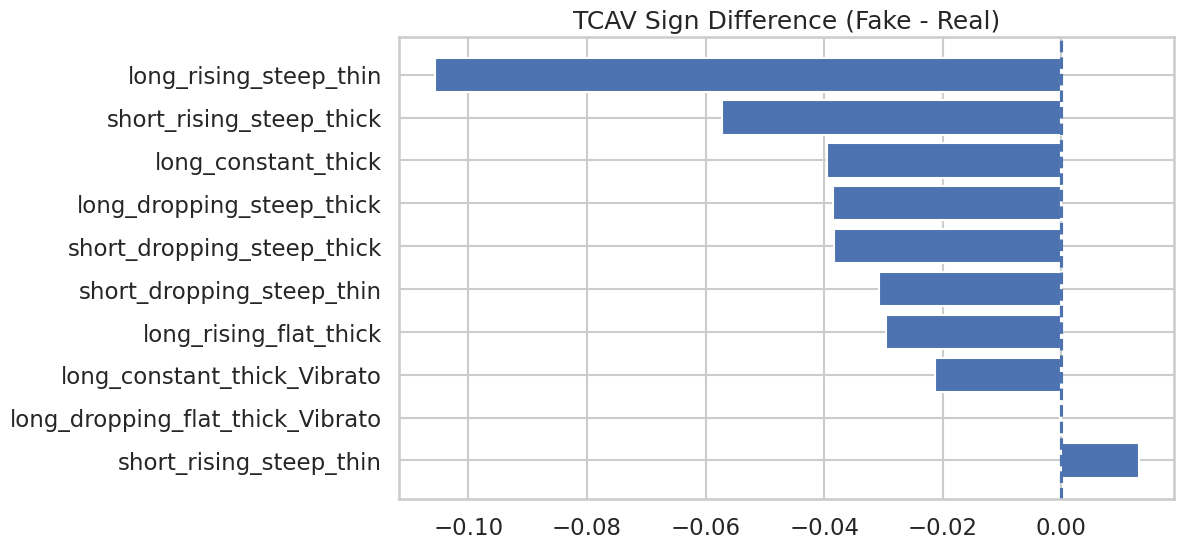

In [5]:

plt.figure(figsize=(10,6))
plt.barh(summary.index, summary["Fake-Real"])
plt.axvline(0, linestyle="--")
plt.title("TCAV Sign Difference (Fake - Real)")
plt.show()


In [6]:

# MAGNITUDE ANALYSIS
mag_summary = (
    df_filtered
    .groupby(["concept name", "true label"])["magnitude"]
    .mean()
    .reset_index()
    .pivot(index="concept name", columns="true label", values="magnitude")
)

mag_summary.columns = ["Real_mag", "Fake_mag"]
mag_summary["Fake-Real_mag"] = mag_summary["Fake_mag"] - mag_summary["Real_mag"]
mag_summary = mag_summary.sort_values("Fake-Real_mag", ascending=False)

mag_summary


,Real_mag,Fake_mag,Fake-Real_mag
concept name,,,
short_rising_steep_thin,0.233645,0.165103,-0.068542
long_dropping_flat_thick_Vibrato,0.241607,0.166013,-0.075594
long_rising_flat_thick,0.179363,0.091911,-0.087453
short_dropping_steep_thin,0.219246,0.103917,-0.115329
long_constant_thick,0.257843,0.121428,-0.136414
short_dropping_steep_thick,0.344651,0.206939,-0.137712
long_constant_thick_Vibrato,0.367448,0.224994,-0.142454
long_dropping_steep_thick,0.225366,0.075407,-0.149959
short_rising_steep_thick,0.312695,0.152469,-0.160225


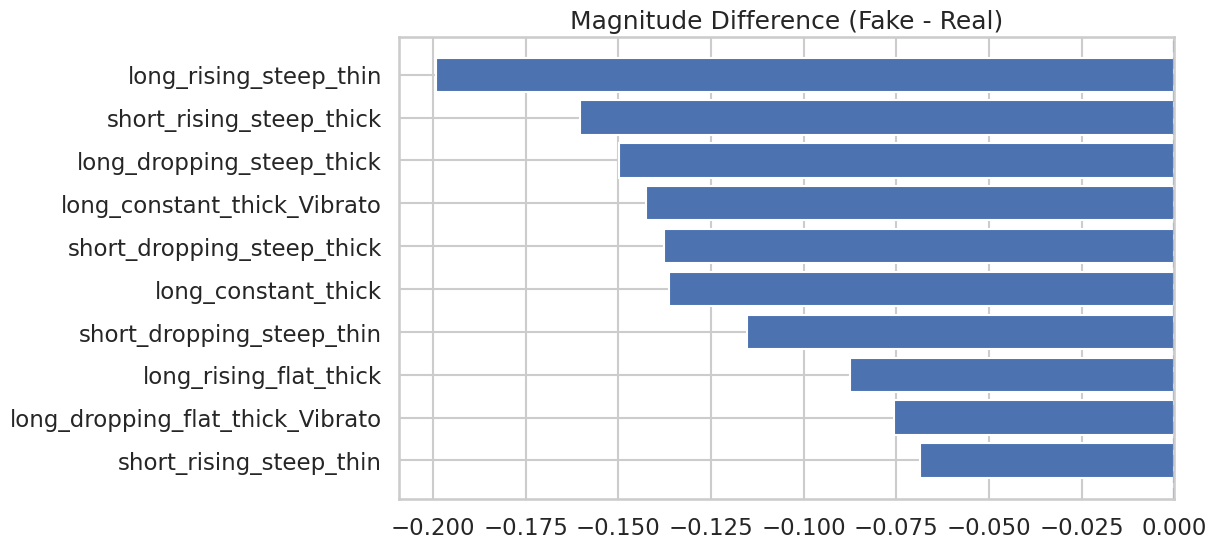

In [7]:

plt.figure(figsize=(10,6))
plt.barh(mag_summary.index, mag_summary["Fake-Real_mag"])
plt.axvline(0, linestyle="--")
plt.title("Magnitude Difference (Fake - Real)")
plt.show()


In [8]:

# COMBINED EFFECT
combined = summary.join(mag_summary[["Fake_mag"]])
combined["Combined_score"] = combined["Fake-Real"] * combined["Fake_mag"]
combined.sort_values("Combined_score", ascending=False)


,Real,Fake,Fake-Real,Fake_mag,Combined_score
concept name,,,,,
short_rising_steep_thin,0.606250,0.619403,0.013153,0.165103,0.002172
long_dropping_flat_thick_Vibrato,0.606250,0.605970,-0.000280,0.166013,-0.000046
long_rising_steep_thin,0.593750,0.488060,-0.105690,0.016022,-0.001693
long_rising_flat_thick,0.593750,0.564179,-0.029571,0.091911,-0.002718
long_dropping_steep_thick,0.593750,0.555224,-0.038526,0.075407,-0.002905
short_dropping_steep_thin,0.608333,0.577612,-0.030721,0.103917,-0.003192
long_constant_thick_Vibrato,0.664583,0.643284,-0.021300,0.224994,-0.004792
long_constant_thick,0.639583,0.600000,-0.039583,0.121428,-0.004807
short_dropping_steep_thick,0.656250,0.617910,-0.038340,0.206939,-0.007934


In [9]:

# STATISTICAL TEST
stats_rows = []

for concept in df_filtered["concept name"].unique():
    fake_vals = df_filtered[
        (df_filtered["concept name"] == concept) &
        (df_filtered["true label"] == 1)
    ]["positive percentage"]

    real_vals = df_filtered[
        (df_filtered["concept name"] == concept) &
        (df_filtered["true label"] == 0)
    ]["positive percentage"]

    t_stat, p_val = ttest_ind(fake_vals, real_vals, equal_var=False)

    stats_rows.append({
        "concept": concept,
        "Fake-Real": fake_vals.mean() - real_vals.mean(),
        "t_stat": t_stat,
        "p_value": p_val
    })

stats_df = pd.DataFrame(stats_rows).sort_values("p_value")
stats_df


,concept,Fake-Real,t_stat,p_value
5,long_rising_steep_thin,-0.105690,-3.568804,0.000375
8,short_rising_steep_thick,-0.057152,-1.981469,0.047799
0,long_constant_thick,-0.039583,-1.365763,0.172307
6,short_dropping_steep_thick,-0.038340,-1.335733,0.181927
3,long_dropping_steep_thick,-0.038526,-1.304132,0.192478
7,short_dropping_steep_thin,-0.030721,-1.046310,0.295662
4,long_rising_flat_thick,-0.029571,-1.001910,0.316621
1,long_constant_thick_Vibrato,-0.021300,-0.749149,0.453937
9,short_rising_steep_thin,0.013153,0.450949,0.652121
2,long_dropping_flat_thick_Vibrato,-0.000280,-0.009569,0.992367


In [10]:

# COHEN'S D
def cohens_d(x, y):
    nx, ny = len(x), len(y)
    dof = nx + ny - 2
    pooled_std = np.sqrt(((nx-1)*x.var() + (ny-1)*y.var()) / dof)
    return (x.mean() - y.mean()) / pooled_std

effect_rows = []

for concept in df_filtered["concept name"].unique():
    fake_vals = df_filtered[
        (df_filtered["concept name"] == concept) &
        (df_filtered["true label"] == 1)
    ]["positive percentage"]

    real_vals = df_filtered[
        (df_filtered["concept name"] == concept) &
        (df_filtered["true label"] == 0)
    ]["positive percentage"]

    d = cohens_d(fake_vals, real_vals)
    effect_rows.append({"concept": concept, "cohens_d": d})

effect_df = pd.DataFrame(effect_rows).set_index("concept")
effect_df.sort_values("cohens_d", ascending=False)


,cohens_d
concept,
short_rising_steep_thin,0.026995
long_dropping_flat_thick_Vibrato,-0.000572
long_constant_thick_Vibrato,-0.044693
long_rising_flat_thick,-0.059821
short_dropping_steep_thin,-0.062448
long_dropping_steep_thick,-0.077838
short_dropping_steep_thick,-0.079579
long_constant_thick,-0.081403
short_rising_steep_thick,-0.117894


In [11]:

# PER-SPEAKER ANALYSIS
speaker_summary = (
    df_filtered
    .groupby(["speaker_id", "concept name", "true label"])["positive percentage"]
    .mean()
    .reset_index()
)

pivot_speaker = speaker_summary.pivot_table(
    index=["speaker_id", "concept name"],
    columns="true label",
    values="positive percentage"
)

pivot_speaker.columns = ["Real", "Fake"]
pivot_speaker["Fake-Real"] = pivot_speaker["Fake"] - pivot_speaker["Real"]
pivot_speaker.reset_index(inplace=True)

speaker_var = pivot_speaker.groupby("concept name")["Fake-Real"].std()

speaker_var


concept name
long_constant_thick                 0.254873
long_constant_thick_Vibrato         0.263871
long_dropping_flat_thick_Vibrato    0.262827
long_dropping_steep_thick           0.268929
long_rising_flat_thick              0.274241
long_rising_steep_thin              0.234057
short_dropping_steep_thick          0.257778
short_dropping_steep_thin           0.250027
short_rising_steep_thick            0.260106
short_rising_steep_thin             0.248390
Name: Fake-Real, dtype: float64

In [12]:

# FINAL EVALUATION
final_eval = summary.copy()
final_eval = final_eval.join(effect_df)
final_eval = final_eval.join(speaker_var.rename("speaker_std"))

final_eval["is_strong"] = (
    (final_eval["Fake-Real"].abs() > 0.15) &
    (final_eval["cohens_d"].abs() > 0.3) &
    (final_eval["speaker_std"] < 0.1)
)

final_eval.sort_values("Fake-Real", ascending=False)


,Real,Fake,Fake-Real,cohens_d,speaker_std,is_strong
concept name,,,,,,
short_rising_steep_thin,0.606250,0.619403,0.013153,0.026995,0.248390,False
long_dropping_flat_thick_Vibrato,0.606250,0.605970,-0.000280,-0.000572,0.262827,False
long_constant_thick_Vibrato,0.664583,0.643284,-0.021300,-0.044693,0.263871,False
long_rising_flat_thick,0.593750,0.564179,-0.029571,-0.059821,0.274241,False
short_dropping_steep_thin,0.608333,0.577612,-0.030721,-0.062448,0.250027,False
short_dropping_steep_thick,0.656250,0.617910,-0.038340,-0.079579,0.257778,False
long_dropping_steep_thick,0.593750,0.555224,-0.038526,-0.077838,0.268929,False
long_constant_thick,0.639583,0.600000,-0.039583,-0.081403,0.254873,False
short_rising_steep_thick,0.654167,0.597015,-0.057152,-0.117894,0.260106,False


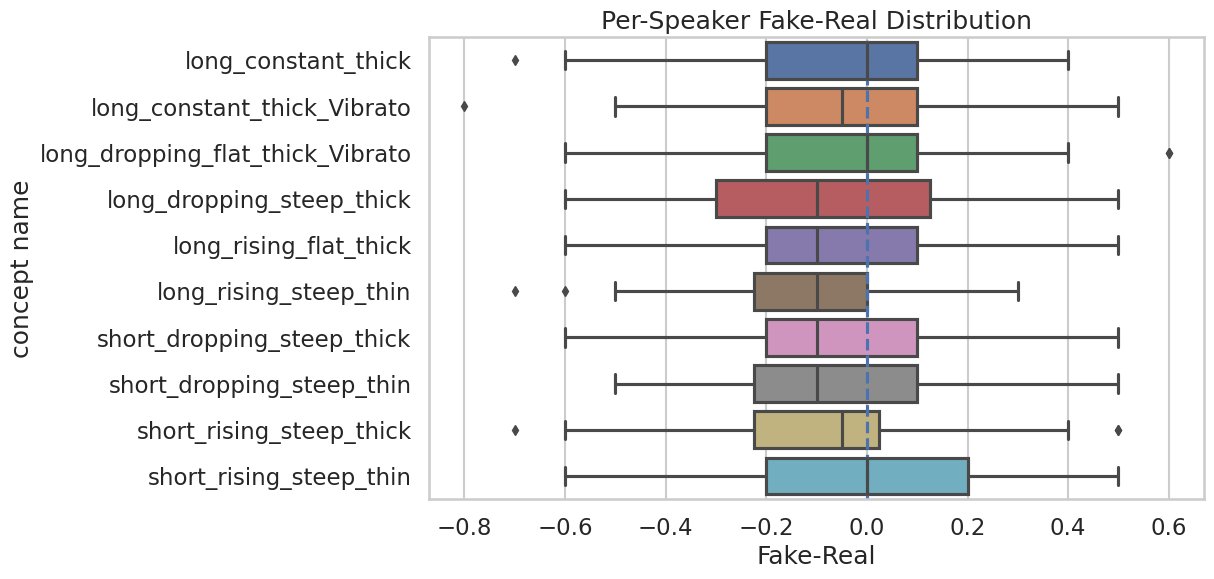

In [13]:

plt.figure(figsize=(10,6))
sns.boxplot(data=pivot_speaker, x="Fake-Real", y="concept name")
plt.axvline(0, linestyle="--")
plt.title("Per-Speaker Fake-Real Distribution")
plt.show()


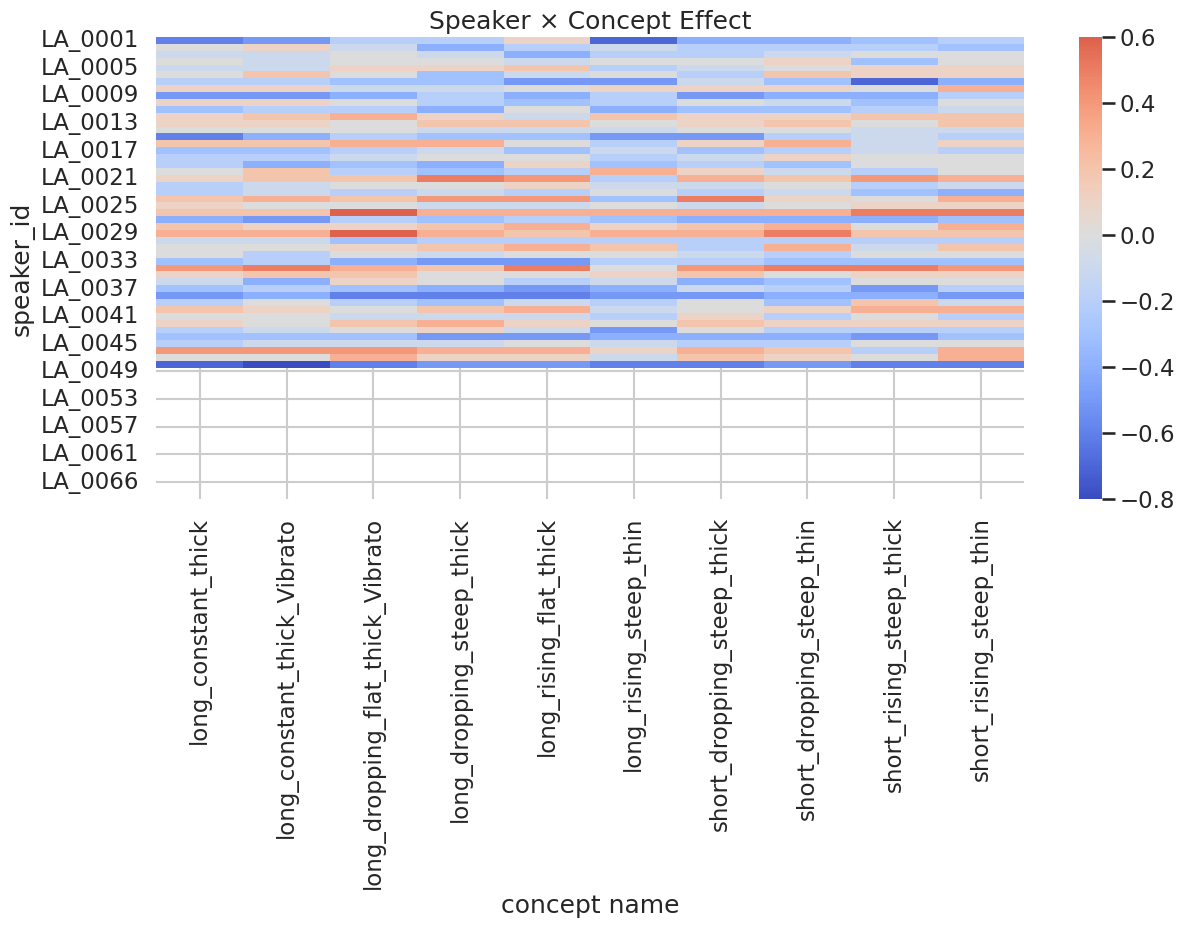

In [14]:

heatmap_data = pivot_speaker.pivot(
    index="speaker_id",
    columns="concept name",
    values="Fake-Real"
)

plt.figure(figsize=(14,6))
sns.heatmap(heatmap_data, cmap="coolwarm", center=0)
plt.title("Speaker × Concept Effect")
plt.show()
